# Wasserstein-based clustering

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from wkmeans import WKMeans
from MAslope import ma_slope

In [2]:
# Data
df = pd.read_parquet("btc_binance_1d.parquet")
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060


In [3]:
# Data
df_features = pd.read_parquet("btc_features.parquet")
df_features.head()

,Returns,feature_1,feature_2,feature_3,feature_4
Date,,,,,
2017-09-16,0.004032,-1.073904,-1.195123,-0.977491,-0.757684
2017-09-17,-0.004035,-0.911085,-1.097203,-0.930232,-0.737324
2017-09-18,0.086679,1.495757,0.169982,-0.099188,-0.168323
2017-09-19,-0.031461,0.311813,-0.270929,-0.370303,-0.353649
2017-09-20,-0.002571,0.168780,-0.269161,-0.360412,-0.347754


In [4]:
# The number of clusters
k = 3

# Define dataset
dataset = df_features.values

# Run WK-mean
wkmeans = WKMeans(k=k)
wkmeans.fit(dataset)

# Predict cluster assignments
df_features['wk'] = wkmeans.predict(dataset)

In [5]:
df['cluster'] = df_features['wk']
df.dropna(inplace=True)

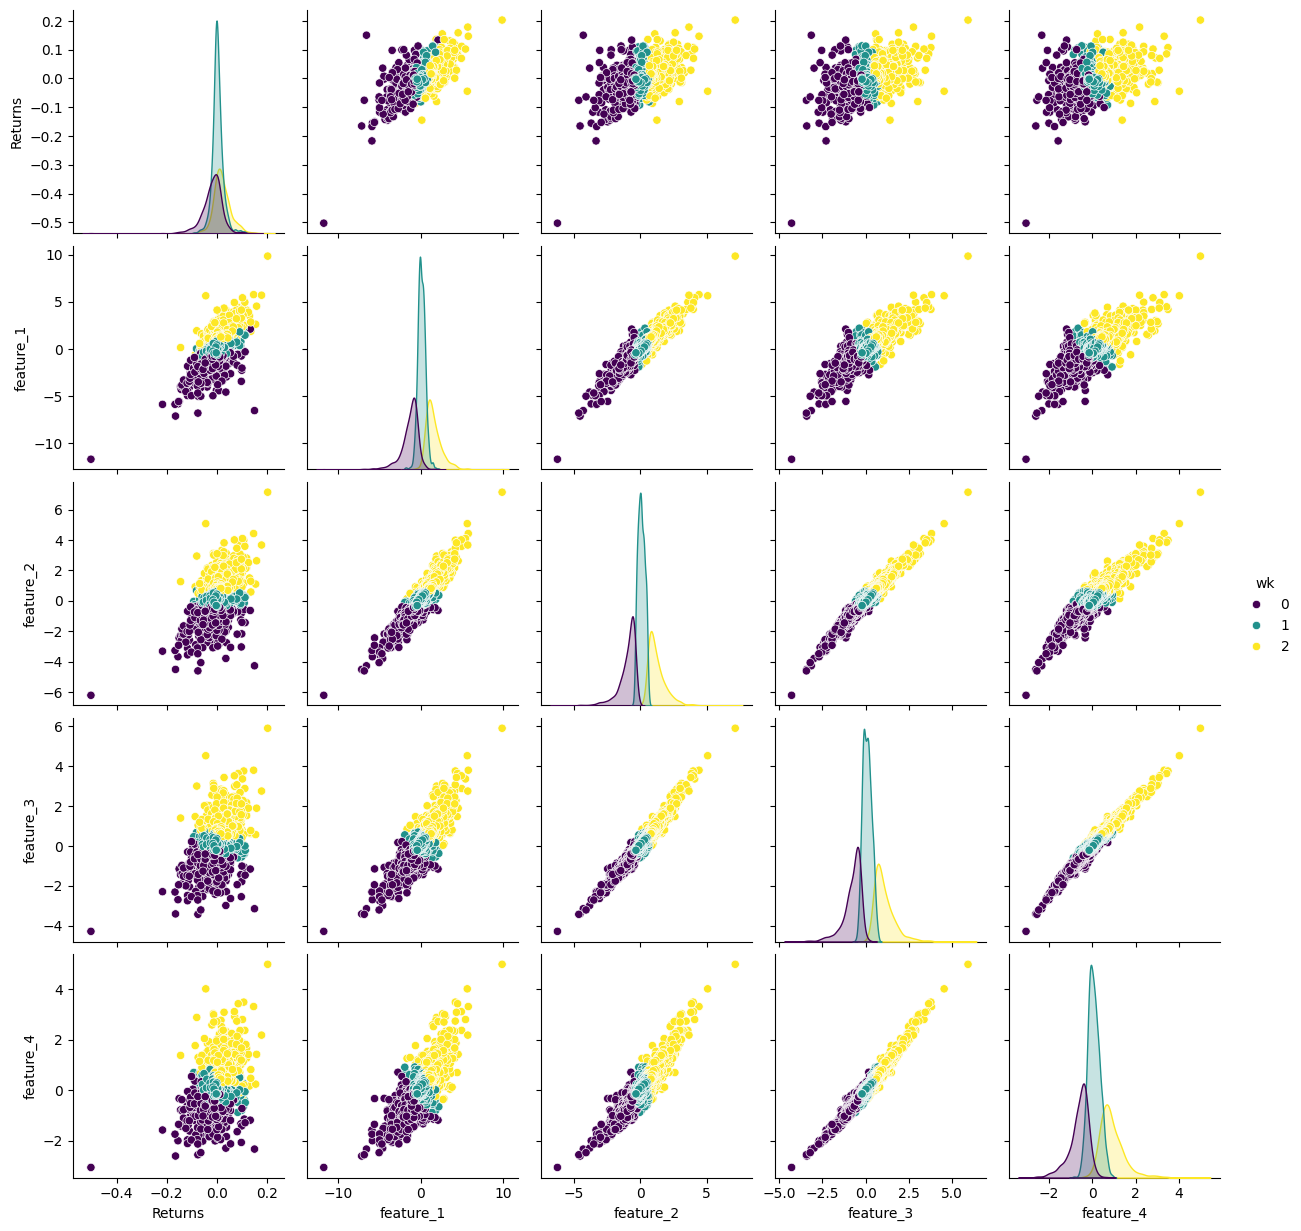

In [6]:
# Plot WK-means
sns.pairplot(df_features, hue='wk', palette='viridis', diag_kind='kde')
plt.show();

In [7]:
close_neutral = df['Close']

colors = {0.0: "red", 1.0: "blue", 2.0: "green"}
close_cluster = {}

for c in colors.keys():
    mask = (df['cluster'] == c) | (df['cluster'].shift(-1) == c)
    series = df['Close'].copy()
    series[~mask] = np.nan
    close_cluster[c] = series

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.7, 0.3],
    subplot_titles=("Price by Cluster", "Assigned Cluster")
)

fig.add_trace(go.Scatter(
    x=df.index, y=close_neutral,
    mode='lines',
    line=dict(color='gray', width=1),
    name='Neutral',
    hoverinfo='skip'
), row=1, col=1)

for c, series in close_cluster.items():
    fig.add_trace(go.Scatter(
        x=df.index, y=series,
        mode='lines',
        line=dict(color=colors[c], width=2.5),
        name=f"Cluster {c}",
        connectgaps=False
    ), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index, y=df['cluster'],
    mode='lines',
    line=dict(color='cyan', width=1),
    name='Cluster'
), row=2, col=1)

fig.update_layout(
    template='plotly_dark',
    height=700,
    title_text="Market Regime Detector (WK-means)",
    hovermode="x unified",
    dragmode='zoom',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.update_xaxes(rangeslider_visible=False)

fig.show();

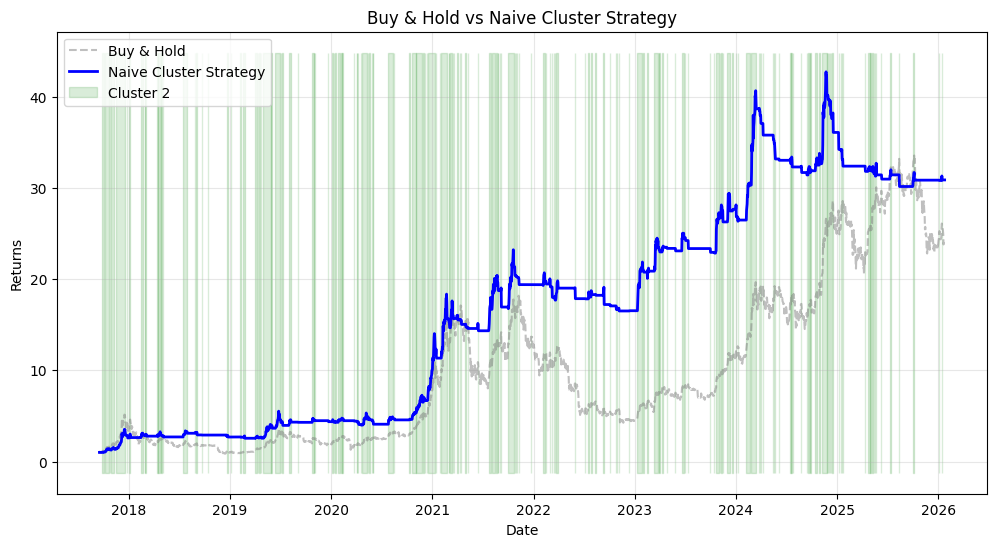

Total Returns Buy & Hold: 2305.63%
Total Returns Naive Cluster Strategy: 2987.86%


In [8]:
df['Returns'] = df['Close'].pct_change()

df['BH_Returns'] = df['Returns'].fillna(0)
df['BH_Cumulative'] = (1 + df['BH_Returns']).cumprod()

is_target_cluster = (df['cluster'] == 2)

df['Signal'] = is_target_cluster.shift(1).fillna(0).astype(int)

df['Strategy_Returns'] = df['Returns'] * df['Signal']
df['Strategy_Cumulative'] = (1 + df['Strategy_Returns']).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['BH_Cumulative'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')

plt.plot(df.index, df['Strategy_Cumulative'], label='Naive Cluster Strategy', color='blue', linewidth=2)

y_min, y_max = plt.ylim()
plt.fill_between(df.index, y_min, y_max, where=(df['cluster'] == 2), 
                 color='green', alpha=0.15, label='Cluster 2')

plt.title('Buy & Hold vs Naive Cluster Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

total_return_bh = (df['BH_Cumulative'].iloc[-1] - 1) * 100
total_return_strat = (df['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Total Returns Buy & Hold: {total_return_bh:.2f}%")
print(f"Total Returns Naive Cluster Strategy: {total_return_strat:.2f}%")